# Musical genre evolution

***"When the words fail, music speaks"**, Hans Christian Andersen*

## Abstract

Our goal was originally to draw an identikit-picture of the different music genres and subgenres. The [Million song](https://labrosa.ee.columbia.edu/millionsong/) dataset provides several criteria like the duration, danceability, loudness, etc... We also wanted to analyze the most prolific types of music over time and understand their evolution.

Since Milestone 1, our idea has evolved. A closer look at the dataset revealed that some information that we wanted to be part of our identikit, such as the energy and the danceability, was missing for a lot of songs in the dataset. Conversely, the location of the song and the date are well defined so we decided to make full use of this information. The goal now, would be to analyse the music genre evolution both geographically and over time. The idea is to show the most popular genre in a certain region at a given year.

The original idea of drawing the portrait of a genre has not been completly dropped but it has became a secondary concern. After having analysed the evolution of genre we will try to find if there is a correlation between the genre and the hotesness or familiarity of the artist.

# NOTEBOOK OVERVIEW
## 1. Dataset description

## 2. Find the genre of a song
** 2.1 Defining genre and subgenre**

** 2.2 Create a first dictionary using beautiful soup**

** 2.3 Enrich our dictionary **

## 3. Create our dataframe
** 3.1 get_genre() **

** 3.2 get_location() **

** 3.3 create_data_frame() **

## 4. First data analysis on different features
** 4.1 Genre**

** 4.2 Year **

** 4.3 Hotttnesss and familiarity **

** 4.4 Duration **

** 4.5 Map visualization **

## 5. Future work


In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from scipy import stats
import seaborn as sns
import re

import tables as tb

import pickle
import requests
import geocoder
from bs4 import BeautifulSoup
from collections import*
import matplotlib
import matplotlib.pyplot as plt
from PythonSrc.hdf5_getters import *

import PythonSrc.hdf5_getters as GETTERS

import os
import sys
import time
import glob
import datetime


import unidecode

%matplotlib inline

## 1. Dataset description

The Million Song Dataset is a collection of audio features and metadata for a million contemporary popular music tracks.

The data are available on h5 files and a python [library](https://github.com/tbertinmahieux/MSongsDB/tree/master/PythonSrc) exists to manage them. To access the different fields in the HDF5 song files provided in the dataset, we mainly use the file `hdf5_getters.py`.

The entire dataset is 280 GB, so we have to use the cluster to work on it. As there were many problems lately with the cluster we decide to work on subset of 10.000 songs provided on the [Million Song DatasetMillion Song Dataset website](https://labrosa.ee.columbia.edu/millionsong/). This subset is organised as the entire dataset. 
The `MillionSongSubset` folder contains a folder `data` which contains all the h5 files in different subfodlder, and a folder `AdditionalFiles` which contains 2 files:

- `subset_unique_terms.txt`
- `subset_unique_mbtags.txt`

with all the different tags that could define a song, for examples, the song *Soul Deep* from *The Box Tops* has the tags:

`'blue-eyed soul' 'pop rock' 'blues-rock' 'beach music' 'soft rock'
 'soul' 'classic rock' 'oldies' 'power pop' 'psychedelic rock' 'rock'
 'sunshine pop' 'blues' 'singer-songwriter' 'pop' 'united states'
 'male vocalist' "rock 'n roll" '60s' 'am pop' 'r&b' 'american'
 'male' 'psychedelic' 'classic' 'vocal' 'americana' 'game music'
 'mod' 'trippy' 'french' 'germany' 'canada' '70s' 'belgium' 'cover'
 'nederland' 'confident'`
 
Those tags will be useful to define the genre of the song. That's why the first part of our work was to define what is a genre and a subgenre. And try to macth all those tags to a genre. And it's not a easy task to classify music genre and classify certain song.


In [5]:
# Path to the Million Song Dataset 
msd_subset_path='MillionSongSubset'
msd_subset_data_path=os.path.join(msd_subset_path,'data')
msd_subset_addf_path=os.path.join(msd_subset_path,'AdditionalFiles')
assert os.path.isdir(msd_subset_path),'wrong path' # sanity check

## 2. Find the genre of a song
### 2.1 Defining genre and subgenre

Our work is based on the different genres and there are so many genres and fusion of genres that it's not easy to choose the main category. This website https://www.quora.com/What-is-the-basic-difference-between-different-genres-of-music-jazz-rock-pop-blues-rap-and-so-on provides us with 12 genres we found meaningfull:
- Blues
- Country
- Electronica
- Folk
- Hip hop (note: we prefer Hip hop than R&B for the name of this category)
- Jazz
- Metal
- Orchestral
- Pop
- Reggae
- Rock
- World

This website also provides us with a list of subgenre for each genre that will be the baseline of our dictionary to match tags to a genre.

### 2.2 Create a first dictionary using beautiful soup

So our first task was to scrap the [website](https://www.quora.com/What-is-the-basic-difference-between-different-genres-of-music-jazz-rock-pop-blues-rap-and-so-on) to create a dictionary that associate a subgenre to its genre.

We create a function **clean_words** to have the terms in the same format:
- without numbers
- without special caracters !?-/;
- without capital letters
- without accent
- without space a the begining and end of the string, and just one space between words
- we also change the word 'hip hop' to 'hiphop' and 'r&b' to 'rnb' as there are common words for the tags.

In [6]:
def clean_word(w):
    #INPUT: word to "clean"
    #OUTPUT: the word after several "cleaning" 
    
    w=w.lower()     # change capital letter to lower ones
    w=unidecode.unidecode(w) #remove accent
    w=re.sub(r'r&b','rnb', w) #change 'r&b' to 'rnb'
    w=re.sub(r'[^\w+]',' ', w)  #remove caracter
    w=re.sub(r'[\b\d+\b]',' ', w) #remove number
    w=' '.join(w.split()) #remove double spaces and spaces at the begining and at the end
    w=re.sub(r'hip hop','hiphop', w) # change 'hip hop' to 'hiphop'
  
    return w

In [7]:
# example of the cleaning done by clean_word()
clean_word(' --> 90s    Hip hop!!   ')

's hiphop'

The scraping takes care of updating the name of the category *r&b* to *hiphop*, and separating the subgenres that were seprated by a `'\'` on the website (e.g. `Irish/Celtic/Gaelic`) into different subgenres. 

**Build a dictionary of the subgenres from the [website](https://www.quora.com/What-is-the-basic-difference-between-different-genres-of-music-jazz-rock-pop-blues-rap-and-so-on)** 

In [10]:
url = "https://www.quora.com/What-is-the-basic-difference-between-different-genres-of-music-jazz-rock-pop-blues-rap-and-so-on"

In [11]:

r = requests.get( url )
page_body = r.text
soup = BeautifulSoup(page_body, 'html.parser')

# Find all genres
genres = soup.findAll("p", class_="qtext_para")

# Where we will store the words of our dictionary
genre_dict = {}

for genre in genres :
    if genre.find('i') :
        
        # Classify the genre as a subgenre of its own genre
        genre_name = genre.find('i').text
        genre_name = clean_word(genre_name) #genre_name.replace(":", "").lower()
        
        # Change the genre rnb to hiphop
        if genre_name=='rnb':
            genre_name='hiphop'
    
        genre_dict[genre_name] = genre_name
        
        
        # Find the subgenres
        subgenres = genre.find_next_sibling('ul')
        if subgenres : 
            subgenres = subgenres.findAll('li')
            
            # Add the subgenres to the disctionary
            for subgenre in subgenres :
                subgenre_name = subgenre.find('i').text
                # If there is a / add all word separatly
                if '/' in subgenre_name:
                    for subsubgenre_name in subgenre_name.split("/"):
                        genre_dict[ clean_word(subsubgenre_name)] = genre_name
                else  : 
                    genre_dict[clean_word(subgenre_name)] = genre_name

print("Dictionary of " + str( len(genre_dict) ) + " subgenres : ")                
genre_dict

Dictionary of 133 subgenres : 


{'acid jazz': 'jazz',
 'adult contemporary': 'pop',
 'african': 'world',
 'alternative': 'rock',
 'alternative hiphop': 'hiphop',
 'ambient': 'electronica',
 'american roots': 'folk',
 'americana': 'rock',
 'art rock': 'rock',
 'asian': 'world',
 'avant garde metal': 'metal',
 'beat pop': 'pop',
 'bebop': 'jazz',
 'big band': 'jazz',
 'black metal': 'metal',
 'bluegrass': 'country',
 'blues': 'blues',
 'blues rock': 'blues',
 'broadway': 'orchestral',
 'celtic': 'world',
 'chicago blues': 'blues',
 'classic metal': 'metal',
 'classic rock': 'rock',
 'classical': 'orchestral',
 'college rock': 'rock',
 'country': 'country',
 'country pop': 'country',
 'dance pop': 'pop',
 'dancehall': 'reggae',
 'dark wave': 'rock',
 'death metal': 'metal',
 'delta blues': 'blues',
 'disco': 'pop',
 'doo wop': 'pop',
 'doom metal': 'metal',
 'dub': 'reggae',
 'dubstep': 'electronica',
 'eastern european': 'world',
 'electric blues': 'blues',
 'electronica': 'electronica',
 'folk': 'folk',
 'folk pop': '

Finally, we notice that some basics music subgenres are missing from our dictionary such as *R&B*, *minimal*, *opera*... Let's associate these terms with the corresponding genre. We also delete alternative as it doesn't belong exclusively to the genre *Rock*

In [12]:
genre_dict["electro"] = "electronica"
genre_dict["electronic"] = "electronica"
genre_dict["minimal"] = "electronica"
genre_dict["opera"] = "orchestral"
genre_dict["rnb"]= "hiphop"

del genre_dict['alternative']

We have build a dictionary containing 137 entries.

### 2.3 Enrich our dictionary 

This dictionary should match the maximum of tags contained in :

- `subset_unique_terms.txt`
- `subset_unique_mbtags.txt`

We first combine those 2 lists, clean each tags with the function `clean_word()` and keep just those that are unique. This is done by the function  `create_list_unique_terms` which takes as input, the path to the folder containing the lists, and the name of those two files and gives as output the combined list.

To enrich our dictionary, we then check for each tags of this list if they are already present on our dictionary.
If not we check each word of the tag separatfly, if they belong to our dictionary. If yes we add the entire tag with the found category. We did this check in the reverse order, as the main genre is usually at the end of the tag: (e.g. *'french rap'*, *'british rock'*)

For example: `'lovers rock'` doesn't belong to our dictionary so we check the word separatly in reverse order:  `'rock'`, `'lovers'`. As `'rock'` belong to our dictionary, we add  `genre_dict['lovers rock']='rock'`.

In [13]:
def create_list_unique_terms(path,list_of_terms_names):
"""    
INPUT:  - path: the path to the folder 'AdditionalFiles'
        - list_of_terms_names: name of the list of tags to combine
OUTPUT: - list_unique_terms: a list of "cleaned" unique tags.
"""
          
    
    list_unique_terms=[]
    for l_name in list_of_terms_names:
        terms= open(os.path.join(path,l_name), 'r') 
        for t in terms:
            clean_t=clean_word(t)
            if clean_t not in list_unique_terms and len(clean_t)>0:
                list_unique_terms.append(clean_t)
                
    return list_unique_terms

def enrich_dictionary(genre_dict,path,list_of_terms_names):
""" 
INPUT: - genre_dict: the dictionary to enrich
       - path: the path to the folder 'AdditionalFiles'
       - list_of_terms_names: name of the list of tags to combine
OUTPUT: - genre_dict: the enriched dictionary 
        - list_not_in_dict : the list of tags we didn't manage to match to a genre
"""
    
    # List of terms extracted from : 'subset_unique_terms.txt','subset_unique_mbtags.txt'
    list_unique_terms=create_list_unique_terms(path,list_of_terms_names)
    list_not_in_dict=[]

    
    # Counter for word : already in dictionary, added in dictionary, still not in dictionary:
    original_len=len(genre_dict)
    already_in_dict=0
    add_in_dict=0
    not_in_dict=0

    for t in list_unique_terms:
        if t in genre_dict:
            already_in_dict+=1
        else :
         
            for w in list(reversed(t.split())):
                if w in genre_dict:
                    category=genre_dict[w]
                    genre_dict[t]=category
                    add_in_dict+=1
                    break
   
        if t not in genre_dict:
            not_in_dict+=1
            list_not_in_dict.append(t)
            
    print('\n #tags that were already in our second dictionary:', already_in_dict,'/', original_len )
    print(' #tags we added in our dictionary :',add_in_dict)
    print(' #tags we did not catch',not_in_dict)
            
    return genre_dict,list_not_in_dict
        
            

In [14]:
list_of_terms_names=['subset_unique_terms.txt','subset_unique_mbtags.txt']
genre_dict,list_not_in_dict=enrich_dictionary(genre_dict,msd_subset_addf_path,list_of_terms_names)


 #tags that were already in our second dictionary: 121 / 137
 #tags we added in our dictionary : 1213
 #tags we did not catch 2396


As you can see on the 137 tags of our first dictionary, 121 were present in the list which is good.
We successfully match 1213 other terms to a genre which gives us a dictionary of 1350 tags

In [15]:
#final lenght of our dictionary
print(len(genre_dict))

1350


Looking at some of the 2396 tags we didn't manage to match, we see that for the most they don't belong to a genre we defined.

In [17]:
for i in range(20):
    print(list_not_in_dict[i])

s
th century
meter sessies
step
tone
bonnaroo
st century
watt club
ad
s lounge
s garage
s girl group
s influenced
s psychedelic and garage
s revival
s spanish
rpm
bit
s goth
s hardcore



## 3. Create our dataframe

### 3.1 get_genre() 

The function get_genre(), takes as input the H5 file and the song_idx (as a H5 could contains dofferent songs). With the function  `get_artist_terms()` we get the list of tags of the corresponding song e.g. for the song *Soul Deep* from *The Box Tops*, we get:

`'blue-eyed soul' 'pop rock' 'blues-rock' 'beach music' 'soft rock'
 'soul' 'classic rock' 'oldies' 'power pop' 'psychedelic rock' 'rock'
 'sunshine pop' 'blues' 'singer-songwriter' 'pop' 'united states'
 'male vocalist' "rock 'n roll" '60s' 'am pop' 'r&b' 'american'
 'male' 'psychedelic' 'classic' 'vocal' 'americana' 'game music'
 'mod' 'trippy' 'french' 'germany' 'canada' '70s' 'belgium' 'cover'
 'nederland' 'confident'`

 
Each of those tags are associated with a weight, that gives the importance of this tags for the song. For the song *Soul Deep* from *The Box Tops*, we get using the function `get_artist_terms_weight()` :
 
  `  1.0         0.8459884   0.83068957  0.79929112  0.7882742   0.78409474
0.78162137  0.77157135  0.76701044  0.76259756  0.74642957  0.72313246
0.71631195  0.69145399  0.68487963  0.68092924  0.66818023  0.65671327
0.64044927  0.62919326  0.62628879  0.62208271  0.60905077  0.60905061
0.60905036  0.60905025  0.6090495   0.60681945  0.60252961  0.59761364
0.56556785  0.55928456  0.55928206  0.5592817   0.55928128  0.55631773
0.54045413  0.53544559`
 
 Using the dictionary  that we created,  we match each of those tags to a genre, and add its weight. 
 For each genre we obtain a cumulative weight. For the song *Soul Deep* from *The Box Tops*, we get 
 
- rock: 4.34
- pop: 3.6502041969675059
- hiphop: 2.41
- blues: 1.5470015243727424,
- orchestral: 0.60905025347785446
- folk , metal, jazz,world, country, electronica: 0

Then we return the genre with the maximum cumulative weight, e.g *rock, 4.34* for the previous example.

As all our study is based on the genre of the song we decide not to take the songs for which the cumulative weight was lower than 1 because this means that just one tag is refering to this genre and it could be biased.            


In [24]:
def get_genre(h5,song_idx):
"""
INPUT:  - h5 : the H5 file
        - song_idx : the song indices in the h5 file
OUTPUT: - the genre of the song
        - the genre cumulative weight obtained from the tags.
"""
    genre_weight={'blues':0,'country':0,'electronica':0,'folk':0,'jazz':0,'pop':0,'metal':0,'rock':0,'orchestral':0,'hiphop':0,'reggae':0,'world':0}
    match=False
    
    for t_idx,t in enumerate(GETTERS.get_artist_terms(h5,song_idx)):
        t=t.decode("utf-8")
        clean_t=clean_word(t)
        if clean_t in genre_dict:
            match=True
            weight=GETTERS.get_artist_terms_weight(h5)[t_idx]
            genre_weight[genre_dict[clean_t]]+=weight
     
    if match==False:
        #print(GETTERS.get_artist_terms(h5,song_idx),'\n')
        return 0,0
    else:
        
        genre=max(genre_weight, key=lambda k: genre_weight[k])
        # if genre_weight[genre]<1.5:
        #    print(genre,genre_weight[genre],'\n',GETTERS.get_artist_terms(h5,song_idx),'\n',genre_weight,'\n')
        return genre,genre_weight[genre]



### 3.2 get_location() 


`get_loc()`, takes as input the H5 file and the song_idx. When the latitude and longitude is not provided it looks if the location is provided, and try to associate the location to a latitude and longitude using gecoder. Below is an example of how geocoder works:

In [19]:
def get_loc(h5,song_idx):
"""
INPUT: - h5 : the H5 file
       - song_idx : the song indices in the h5 file
OUTPUT: - the latitude and the longitude of the song producer location
"""
    lat = GETTERS.get_artist_latitude(h5)
    lng = GETTERS.get_artist_longitude(h5)
    location = GETTERS.get_artist_location(h5).decode("utf-8")
    
    
    if np.isnan(lat) and location != "":
        #print(row.location)
        g = geocoder.arcgis(location)
        try:
            lat,lng = g.latlng
        except:
            print("except")
            lat,lng = np.nan,np.nan
 
    return lat,lng   


### 3.3 create_data_frame() 

**create_data_frame**

Given the path of the Million Song data folder, the function `create_data_frame` loads each h5 files and for each song of this h5 files, extracts:
    
- The genre (with get_genre)
- the weight of genre
- the year,                        todo transform year to a pd.date? 
- the location (latitude, longitude)
- the duration of the song
- Familiarity – this corresponds to how well known an artist is.  You can look at familiarity as the likelihood that any person selected at random will have heard of the artist.  Beatles have a familiarity close to 1, while a band like ‘Hot Rod Shopping Cart’ has a familiarity close to 0.
- Hotttnesss – this corresponds to how much buzz the artist is getting right now. This is derived from many sources, including mentions on the web, mentions in music blogs, music reviews, play counts, etc.

In [22]:
def create_data_frame(data_path):
    columns = ['genre','genreweight','year','duration','hotttnesss','familiarity','latitude','longitude']
    dataset=pd.DataFrame(columns=columns)

    for root, dirs, files in os.walk(data_path):
        
        files = glob.glob(os.path.join(root,'*'+'.h5'))
        
        for f in files:
                
            h5 = GETTERS.open_h5_file_read(f)
            
            for song_idx in range(GETTERS.get_num_songs(h5)): 
                
                genre,weight = get_genre(h5,song_idx)
               
                if weight>=1:
                    year = GETTERS.get_year(h5,song_idx)   
                    lat,lng = get_loc(h5,song_idx)
                    hotttnesss = GETTERS.get_artist_hotttnesss(h5,song_idx)
                    familiarity = GETTERS.get_artist_familiarity(h5,song_idx)
                    duration = GETTERS.get_duration(h5,song_idx)
                    
                    song_df=pd.DataFrame([[genre,weight,year,duration,hotttnesss,familiarity,lat,lng]],columns=columns)         
                    dataset=dataset.append(song_df,ignore_index=True)#add index    
                    
            h5.close()
            
        
    return dataset

In [23]:
df = create_data_frame(msd_subset_data_path)

except
except
except


In [2]:
cache_path = "cache/"
def get_data(name_file):
    '''Create and cache JSON data, return as a dataframe.'''
    path = cache_path + name_file
    try:        
        f = open(path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(path))
    except (OSError, IOError) as e:
        df = create_data_frame(msd_subset_data_path)
        
        df.to_pickle(path)
        print('Cached {} at {}'.format(path))
    return df

def save_data(df,name_file):
    path = cache_path + name_file
    df.to_pickle(path)


In [3]:
df = get_data("df_new")

Loaded cache/df_new from cache


In [37]:
print('On 10000 samples we kept: ', len(df))
df.head(5)

On 10000 samples we kept:  9378


,genre,genreweight,year,duration,hotttnesss,familiarity,latitude,longitude
0,hiphop,6.498262,0,218.93179,0.401998,0.581794,34.05223,-118.24368
1,rock,4.344685,1969,148.03546,0.417500,0.630630,35.14968,-90.04892
2,rock,7.587840,1982,233.40363,0.454231,0.630382,51.50642,-0.12721
3,rock,9.095158,2007,209.60608,0.401724,0.651046,NaN,NaN
4,blues,1.660828,0,267.70240,0.385471,0.535293,NaN,NaN


## 4. First data analysis on different features
### 4.1 Genre


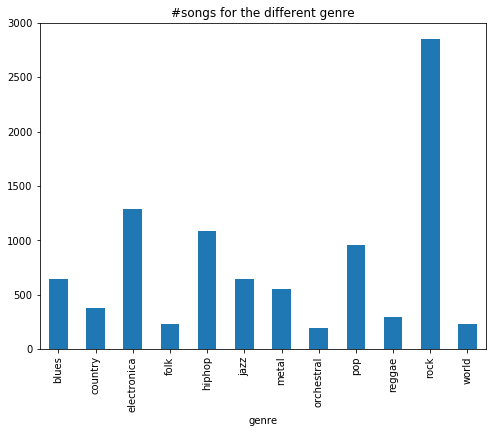

In [38]:
fig = plt.figure(figsize=(8,6))
df.groupby('genre')['genre'].count().plot('bar',title='#songs for the different genre')

**Choose color(meaningfull) for each genre: **
https://xkcd.com/color/rgb/

As we will compare the different genre we try to attribute to each genre a "meaningfull" color (e.g metal:black, blues: light blue ...) 

In [4]:
genre_color={'blues':'#75bbfd','country':'#653700','electronica':'#9a0eea','folk':'#f97306','jazz':'#fac205',
             'pop':'#ff81c0','metal':'#000000','rock':'#2242c7','orchestral':'#929591','hiphop':'#e50000',
             'reggae':'#02ab2e','world':'#a0bf16'}

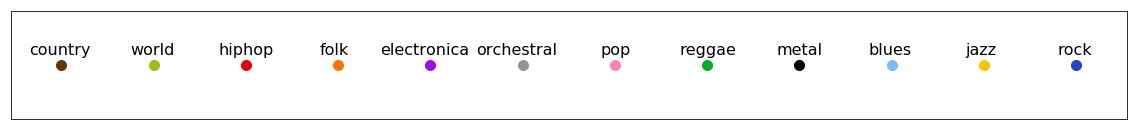

In [93]:
plt.figure(figsize=(20, 2))
for i,genre in enumerate(genre_color):
    plt.plot(2*i,0, marker='o',c=genre_color[genre], markersize=10)
    plt.text(2*i-0.1*len(genre),0.01, genre, fontsize=16)
    plt.xticks([])
    plt.yticks([])

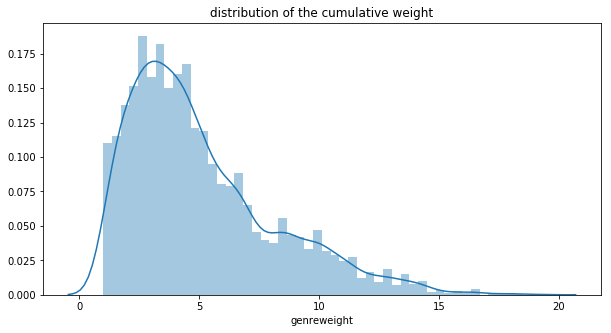

In [94]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.title('distribution of the cumulative weight')
sns.distplot(df['genreweight'],ax=ax)


### 4.2 Year



In [15]:
print("Number of row w/o value for year : ", len( df[ df['year']==0 ] ) )

Number of row w/o value for year :  4788


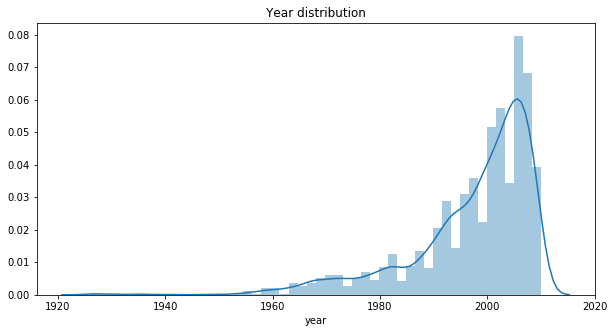

In [95]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.title('Year distribution')
df['year'] = df['year'].astype(int)
sns.distplot(df.loc[df['year']!=0,'year'],ax=ax)

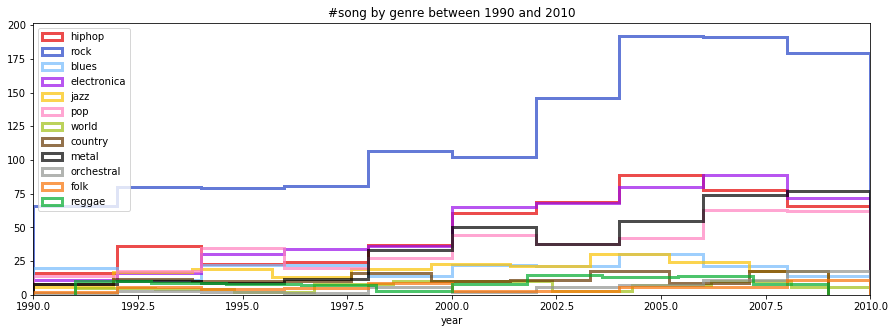

In [96]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
for genre in df['genre'].unique():
    dt=df[df['genre']==genre]
    
    g=sns.distplot(dt['year'][dt['year']>1989],bins=10, hist_kws={"histtype": "step", "linewidth": 3,"alpha": 0.7, "color": genre_color[genre]},norm_hist=False,hist=True,kde=False,label=genre,ax=ax)
    g.set(xlim=(1990, 2010))
    g.legend(loc='upper left')
    
plt.title('#song by genre between 1990 and 2010')
  


The aim is to obtain something like this:

<img src="https://newartistmodel.com/wp-content/uploads/2014/11/Screen-Shot-2014-10-28-at-11.22.14-PM.png">

## 4.3 Hotttnesss & Familiarity

In [5]:
print('hotttnesss=0',len(df[df['hotttnesss']==0]))
print('familiarity=0',len(df[df['familiarity']==0]))

hotttnesss=0 327
familiarity=0 12


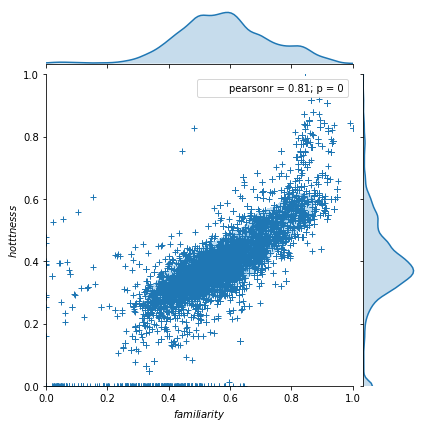

In [31]:
fig = plt.figure(figsize=(10,5))
g = sns.jointplot(x="familiarity", y="hotttnesss", data=df, kind="kde",xlim=[0,1], ylim=[0,1])
g.plot_joint(plt.scatter, s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$familiarity$", "$hotttnesss$");

We can see a correlation between hotttnesss and familiarity.

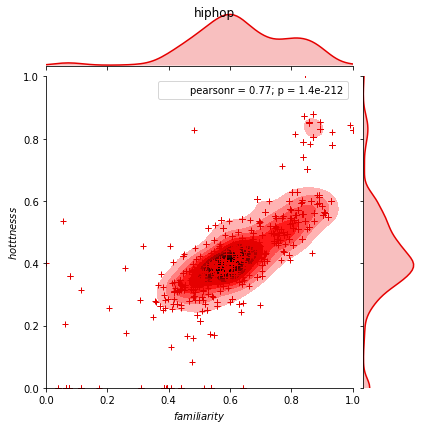

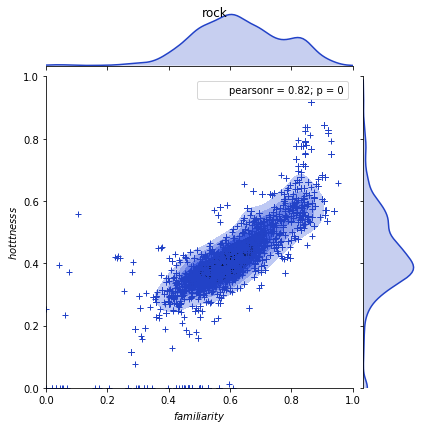

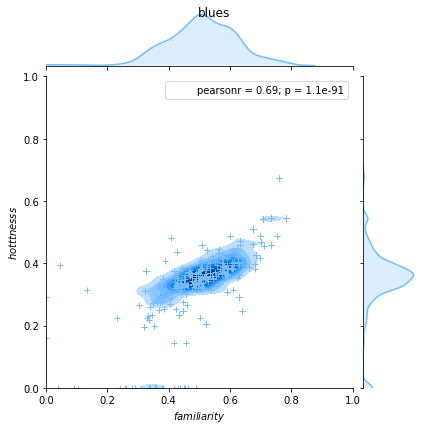

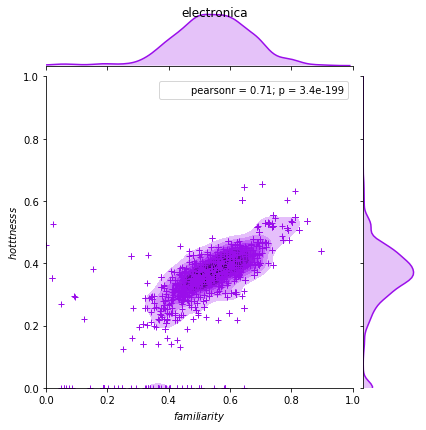

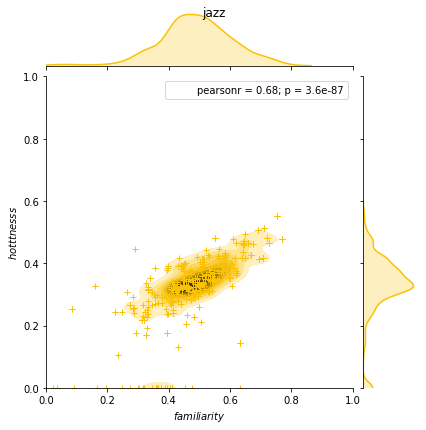

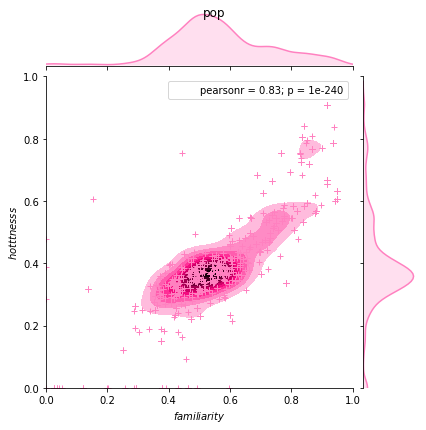

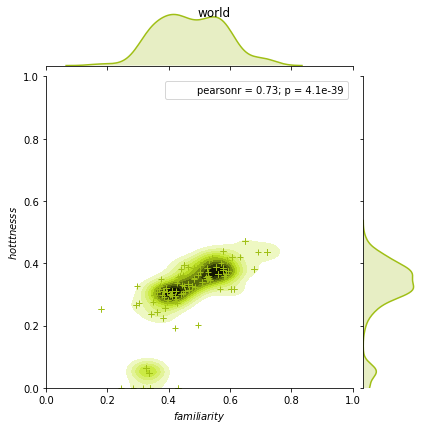

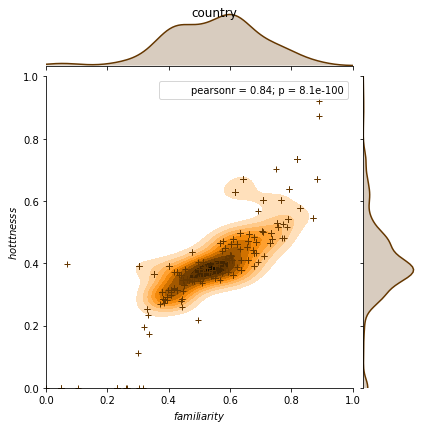

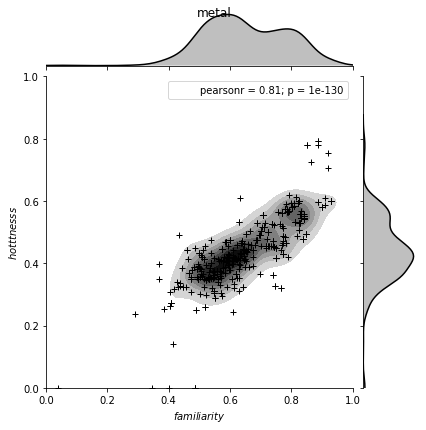

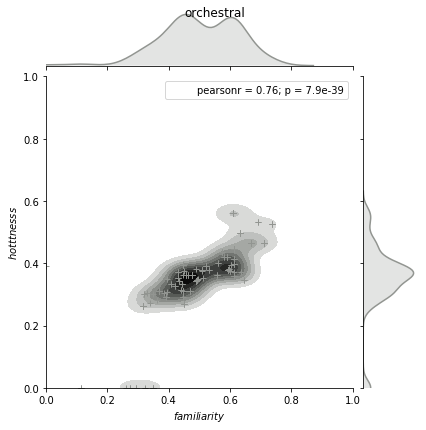

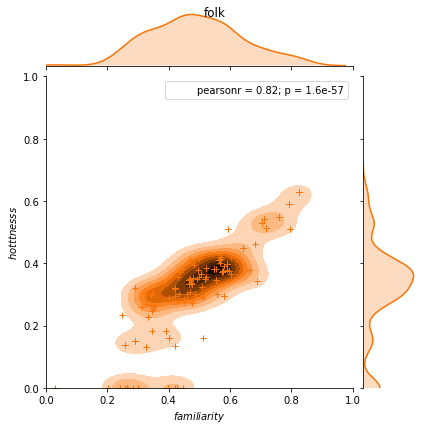

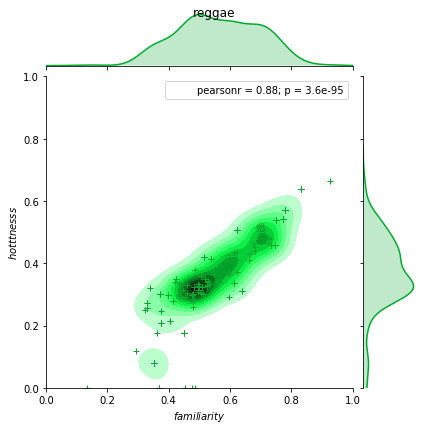

In [6]:
for genre in df['genre'].unique():
    g = sns.jointplot(x="familiarity", y="hotttnesss", data=df[df['genre']==genre], kind="kde",xlim=[0,1], ylim=[0,1],color=genre_color[genre])
    g.plot_joint(plt.scatter, s=30, linewidth=1, marker="+",color=genre_color[genre])
    g.ax_joint.collections[0].set_alpha(0)
    g.set_axis_labels("$familiarity$", "$hotttnesss$");
    g.set_axis_labels("$familiarity$", "$hotttnesss$");
    g.fig.suptitle(genre)

## 4.4 Song duration

The song duration looks like a perfect gaussian , we could have expect to see 2 pics. 

#duration=0 :  0


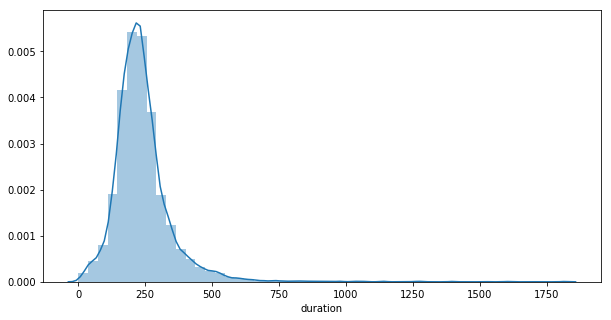

In [98]:
print('#duration=0 : ',len(df[df['duration']==0]))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
sns.distplot(df['duration'][df['duration']!=0],ax=ax)

Looking at the distribution of the different genre separetly. One can see that some genre have a more broader distribution than others. The distrbution of elctronic music is really flat as there is longer songs.

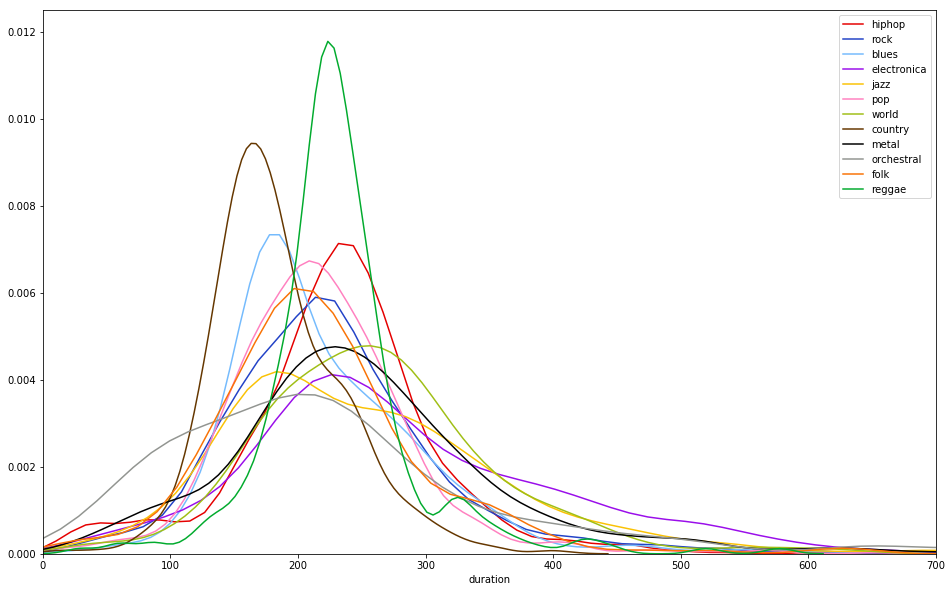

In [108]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for genre in df['genre'].unique():
    dt=df[df['genre']==genre]
    g =sns.distplot(dt['duration'][dt['duration']!=0],hist=False,label=genre,color=genre_color[genre],ax=ax)
    g.set(xlim=(0, 700),ylim=(0,0.0125))
    

### Map visualization
Let's display the rock music evolution over time

In [102]:
import folium
from folium import plugins

map_hooray = folium.Map([48., 5.], tiles='stamentoner', zoom_start=2) 

data = df.loc[df.genre == "rock"]

# Ensure you're handing it floats
#data['latitude'] = data['latitude'].astype(float)
#data['longitude'] = data['longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = data.dropna()
heat_df = data.loc[data.year != 0]
heat_df = heat_df[['latitude', 'longitude']]

# Create weight column, using date
heat_df['Weight'] = data['year']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude', 'Weight'])

# List comprehension to make out list of lists
heat_data = [[[row['latitude'],row['longitude']] for index, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in range(1955,2000)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray

## 5. Future Work
### Visualizations

#### Music genre analysis
- Display what define a music genre
- Draw portraits of musical genres
#### Music genre evolution over time and location
- Display a music genre propagation over time on an interactive map
- Display the music genres production over time